```{=latex}
\usepackage{hyperref}
\usepackage{graphicx}
\usepackage{listings}
\usepackage{textcomp}
\usepackage{fancyvrb}

\newcommand{\passthrough}[1]{\lstset{mathescape=false}#1\lstset{mathescape=true}}
```

```{=latex}
\title{Jupyter as Your Incident Management Tool}
\subtitle{DevOps as Science}
\author{Moshe Zadka -- https://cobordism.com}
\date{2020}

\begin{document}
\begin{titlepage}
\maketitle
\end{titlepage}

\frame{\titlepage}
```

In [69]:
from PIL import Image
import httpx
import collections
import operator
import datetime

```{=latex}
\begin{frame}
\frametitle{Acknowledgement of Country}

Belmont (in San Francisco Bay Area Peninsula)

Ancestral homeland of the Ramaytush Ohlone

\end{frame}
```

## Intro to Jupyter

### Notebooks

```{=latex}
\begin{frame}
\frametitle{Jupyter Notebooks}

\begin{itemize}
\item Language agnostic console
\item Saves inputs/outputs in JSON
\item Can export to HTML, Markdown, etc.
\end{itemize}
\end{frame}
```

### Kernels

```{=latex}
\begin{frame}
\frametitle{Jupyter Kernels}

\begin{itemize}
\item Language execution engine
\item IPyKernel in a virtual environment
\end{itemize}
\end{frame}
```

### Data Science Origins

```{=latex}
\begin{frame}
\frametitle{Data Science Origins}

\begin{itemize}
\item Sharing work
\item Executable format
\item Exploration
\end{itemize}
\end{frame}
```

## Demo incident -- slowdown

### Stack

```{=latex}
\begin{frame}
\frametitle{Imaginary Stack}

\begin{itemize}
\item Some vague "Service"
\item Our team is in charge of its SLAs
\item As luck would have it, a page comes in...
\end{itemize}
\end{frame}
```

### Symptom

```{=latex}
\begin{frame}
\frametitle{Symptom}

\begin{itemize}
\item P90 latency is spiking
\item Each server has different "typical behavior"
\item Figure out which server is misbehaving and fix
\end{itemize}
\end{frame}
```

### Spoiler

```{=latex}
\begin{frame}
\frametitle{Spoiler}

\begin{itemize}
\item Not a detective story! 
\item Core file dumped resulting in some queries take too long
\end{itemize}
\end{frame}
```

## Querying and analyzing operational data

### Query

```{=latex}
\begin{frame}[fragile]
\frametitle{Spoiler}
```

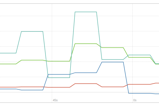

In [78]:
image = Image.open("prometheus.png")
width, height = image.size
image.resize((width//4, height//4))

```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}[fragile]
\frametitle{Query Data}
```

In [82]:
now = datetime.datetime.now()
five_minutes_agp = (
    now - datetime.timedelta(minutes=5))
data = httpx.get(
    f"http://localhost:9090/api/v1/query_range"
    "?query=level"
    f"&start={five_minutes_agp.timestamp()}"
    f"&end={now.timestamp()}&step=10s").json()

In [84]:
(data["data"]["result"][0]["metric"],
 data["data"]["result"][0]["values"][:2])

({'__name__': 'level',
  'instance': 'localhost:8080',
  'job': 'my_service',
  'which': 'object1'},
 [[1605230830.588, '0.11407403763077273'],
  [1605230840.588, '0.6268484040376028']])

```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}[fragile]
\frametitle{Analyze Data}
```

In [44]:
amplitudes = {}
for result in data["data"]["result"]:
    which = result["metric"]["which"]
    values = [float(value)
              for when, value in result["values"]]
    amplitudes[which] = max(values) - min(values)
max(amplitudes.items(), 
    key=operator.itemgetter(1))

('object4', 13.641418227003584)

```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}
\frametitle{We Know The Culprit}

That dastardly object4!\pause

Now let's find out what the problem is.
\end{frame}
```

## Using Cloud API from Jupyter

### Boto3

In [45]:
import json
import boto3

```{=latex}
\begin{frame}[fragile]
\frametitle{Boto3}
```

In [46]:
with open("aws_params.json") as fpin:
    params = json.loads(fpin.read())

ec2 = boto3.client("ec2", **params)

```{=latex}
\end{frame}
```

### Check EC2 Instances

```{=latex}
\begin{frame}[fragile]
```

In [49]:
instances = ec2.describe_instances()
for reservation in instances["Reservations"]:
    for instance in reservation["Instances"]:
        for tag in instance.get("Tags", []):
            if (tag["Key"] == "kind" 
                and tag["Value"] == "object4"):
                object4_instance = instance
print(object4_instance["InstanceId"])

i-6e02ec9badfdcc9f5


```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}
\frametitle{We Know The Culprit}

We Found the instance\pause

i-something-or-other\pause

Time to fix the issue
\end{frame}
```

## Using Paramiko

### Paramiko

In [50]:
import paramiko

```{=latex}
\begin{frame}[fragile]
\frametitle{Connect to Host}
```

In [59]:
client = paramiko.SSHClient()
client.set_missing_host_key_policy(
    paramiko.client.WarningPolicy)
client.connect(
    object4_instance["PrivateIpAddress"],
    username="root")

/home/moshez/.virtualenvs/jupyter-incident/lib/python3.8/site-packages/paramiko/client.py:835: UserWarning: Unknown ssh-ed25519 host key for 172.17.0.2: b'f8b3488df2a6cb911103b31345113e37'
  warnings.warn(


```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}[fragile]
\frametitle{Confirm the Problem}
```

In [60]:
stdin, stdout, stderr = client.exec_command('ls')
stdin.close()
print(stdout.read().decode("utf-8"))

core



```{=latex}
\end{frame}
```

```{=latex}
\begin{frame}[fragile]
\frametitle{Fix the Problem}
```

In [67]:
stdin, stdout, stderr = client.exec_command(
    'rm ~/core')
stdin.close()
stdin, stdout, stderr = client.exec_command('ls')
print("------\n", 
      stdout.read().decode("utf-8"), 
      "\n------")

------
  
------


```{=latex}
\end{frame}
```

## Attach Notebooks

```{=latex}
\begin{frame}
\frametitle{Post-Incident}

\begin{itemize}
\item Duplicate notebook \pause
\item Add notes in Markdown \pause
\item Export to HTML
\item Attach HTML + Notebook to incident ticket
\end{itemize}
\end{frame}
```

## Final Thoughts

```{=latex}
\begin{frame}
\frametitle{Final Thoughts}

\begin{itemize}
\item Incident resolution is exploratory \pause
\item This is not an auditing tool! \pause
\item Share knowledge \pause
\item Be prepared for retrospective
\end{itemize}
\end{frame}
```

```{=latex}
\end{document}
```